# 通过 PyTorch 构建神经网络

深度学习网络一般量级都很大，包含数百个层级，这也是为什么叫“深度”学习网络。你可以像在上个 notebook 展示的一样，仅使用权重矩阵构建深度网络，但是这通常很繁琐并且不好实施。PyTorch 有一个很方便的模块 `nn`，可以有效地构建大型神经网络。

In [8]:
#Import necessary packages

%matplotlib inline
%config InlineBacked.figure_format = 'retina'

import numpy as np
import torch 

import helper

import matplotlib.pyplot as plt

 现在我们要构建一个大型网络，并用它解决识别图像中的文字的这一难题。我们将使用 MNIST 数据集，这个数据集由灰色的手写数字组成。每个图像都是 28x28，如以下示例所示：

<img src='assets/mnist.png'>

我们的目标是构建一个神经网络，可以预测图像中的数字。

首先，我们需要获取数据集。这些数据位于 `torchvision` 软件包中。以下代码将下载 MNIST 数据集，然后为我们创建训练数据集和测试数据集。不用太在意细节内容，稍后会详细学习的。

In [10]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/zhanghao/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /home/zhanghao/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/zhanghao/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/zhanghao/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/zhanghao/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/zhanghao/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/zhanghao/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/zhanghao/.pytorch/MNIST_data/MNIST/raw



我们将训练数据加载到 `trainloader` 中，并使用 `iter(trainloader)` 使其变成迭代器。之后，我们将用它循环访问数据集以进行训练，例如

In [11]:
for image, label in trainloader:
    ## do things with images and labels

SyntaxError: unexpected EOF while parsing (153283872.py, line 2)

我在创建 `trainloader` 时，将批次大小设为 64，并设置为 `shuffle=True`。批次大小是指我们在一次迭代中从数据加载器获取并经过网络的图像数量。`shuffle=True` 表示每次重新访问数据加载器时，随机重排数据集。但是现在我仅获取第一批数据，以便查看数据。从下方可以看出，`images` 是一个张量，大小为 `(64, 1, 28, 28)`。因此，每批有 64 个图像，图像有 1 个颜色通道，共有 28x28 个图像。

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


下面是一个图像示例。

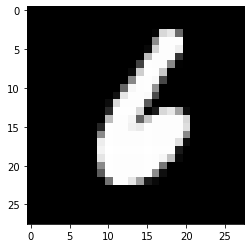

In [13]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

![png](output_7_0.png)


首先，我们要使用权重矩阵和矩阵乘法，用此数据集构建一个简单的网络。然后，我们将学习如何使用 PyTorch 的 `nn` 模块构建该网络。

神经网络又称为*全连接*或*密集*网络。一个层级中的每个单元都与下个层级中的每个单元相连。在全连接网络中，每个层级的输入必须是一维向量（可以作为一批样本堆叠为二维张量）。但是，我们的图像是 28x28 二维张量，因此我们需要将其转换为一维向量。考虑到大小问题，我们需要将形状为 `(64, 1, 28, 28)` 的批次图像变形为 `(64, 784)`，784 等于 28 x 28。这一步通常称为*扁平化*，我们将二维图像扁平化为一维向量。

之前，我们试过了构建具有一个输出单元的简单网络。现在，我们需要 10 个输出单元，每个数字对应一个单元。如果要预测出图像中显示的数字，我们必须计算该图像属于任何数字或类别的概率。我们会得到一个离散概率分布，告诉我们图像最有可能属于哪个类别。这就是说，我们需要 10 个输出单元，对应 10 个类别（数字）。下面讲解如何将网络输出转换为概率分布。

> **练习：**将 `images`扁平化。然后构建一个多层网络，有 784 个输入单元、256 个隐藏单元和 10 个输出单元，并对权重和偏差使用随机张量。目前，我们对隐藏层使用 S 型激活函数。输出层暂时不需要激活函数，下一步我们将添加计算概率分布的激活函数。

In [15]:
## Solution
def activation(x):
    return 1 / (1 + torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2
out

tensor([[-1.3330e+01,  3.2714e+00,  1.9392e+00, -5.6738e+00, -8.6151e+00,
         -5.5143e+00, -3.4845e+01,  1.0504e+01, -4.7842e+00, -2.6091e+00],
        [-1.7182e+01,  8.6651e-01,  4.1029e+00, -9.4886e-02, -1.0270e+01,
         -1.3515e+01, -2.4842e+01, -4.4554e-01, -5.8787e+00, -5.5304e+00],
        [-1.2459e+01,  5.2164e-01, -6.0287e+00, -7.4470e+00,  3.2531e-02,
         -1.6654e-01, -1.4557e+01,  5.1409e+00, -1.3022e+01, -2.4316e+00],
        [-2.1909e+01, -5.6417e+00,  1.4123e+00, -2.5683e+00, -1.1528e+01,
         -5.6577e+00, -1.9717e+01,  3.1358e+00, -7.0667e+00, -1.4464e+00],
        [-3.8581e+00,  8.3600e+00, -7.7744e+00,  1.2372e+01, -1.5214e+01,
         -1.2352e+01, -1.8109e+01,  2.1590e+01,  2.4696e+00,  4.2103e-02],
        [-1.0319e+01,  6.7724e+00, -3.9803e+00, -3.2709e+00, -8.2420e+00,
         -6.8757e+00, -2.0178e+01,  6.9778e+00, -4.8825e+00, -8.1934e+00],
        [ 4.7543e-01,  7.7263e+00, -8.1175e-01,  8.7420e+00, -7.5917e+00,
         -1.5677e+01, -2.1076e+0

现在网络有 10 个输出了。我们向网络中传入一个图像，并获得类别概率分布，告诉我们图像最有可能属于哪个数字/类别。结果如下所示：
<img src='assets/image_distribution.png' width=500px>

可以看出每个类别的概率大致相等。这是未训练网络的结果，网络尚未见过任何数据，因此返回均匀分布，每个类别的概率相等。

可以用 [**softmax** 函数]计算概率分布(https://en.wikipedia.org/wiki/Softmax_function)。数学公式为：

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

它会将每个输入 $x_i$ 都缩放到 0 和 1 之间并标准化值，得出标准概率分布，其中概率总和是 1。

> **练习：**实现一个进行 softmax 运算的函数 `softmax` ，并针对批次中的每个样本返回概率分布。注意，在运算时需要注意形状。如果有一个张量 `a` 的形状为 `(64, 10)`，另一个张量 `b` 的形状为 `(64,)`，进行 `a/b` 运算将出错，因为 PyTorch 会对列进行除法运算（称为广播），但是大小不匹配。提示：对于 64 个样本中的每个样本，你可以除以一个值，即分母中的和。因此需要使 `b` 变形为 `(64, 1)`。这样的话，PyTorch 将使 `a` 中每行的10 个值除以 `b` 中每行的一个值。另外，要注意求和的方式。你要在 `torch.sum` 中定义 `dim` 。`dim=0` 会对行求和，而 `dim=1` 会对列求和。

In [16]:
## Solution
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## 通过 PyTorch 构建网络

PyTorch 提供了`nn`模块，大大地简化了网络构建过程。我将演示如何构建上述同一个网络，即包含 784 个输入、256 个隐藏单元、10 个输出单元和一个 softmax 输出。

In [17]:
from torch import nn

In [18]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

分步讲解

In [19]:
class Network(nn.Module):

SyntaxError: unexpected EOF while parsing (2511390034.py, line 1)

先继承 `nn.Module`。与 `super().__init__()` 相结合，创建一个跟踪架构的类，并提供大量有用的方法和属性。注意，在为网络创建类时，必须继承 `nn.Module`。类可以随意命名。

In [20]:
self.hidden = nn.Linear(784, 256)

NameError: name 'self' is not defined

这行创建一个线性转换模块 $x\mathbf{W} + b$，其中有 784 个输入和 256 个输出，并赋值给 `self.hidden`。该模块会自动创建权重和偏差张量，供我们在 `forward` 方法中使用。创建网络 (`net`) 后，你可以使用 `net.hidden.weight` 和 `net.hidden.bias` 访问权重和偏差张量。